In [305]:
import pandas
import numpy as np
import csv
%matplotlib inline
import matplotlib.pyplot as plot
import sklearn.linear_model
from sklearn.impute import KNNImputer
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from functools import partial

In [306]:
#import and read files
df_cleveland = pandas.read_csv("processed.cleveland_H.data", sep=",",encoding='unicode_escape', header=None)
df_hungarian = pandas.read_csv("processed.hungarian_H.data", sep=",",encoding='unicode_escape', header=None)
df_switzerland = pandas.read_csv("processed.switzerland_H.data", sep=",",encoding='unicode_escape', header=None)
df_va = pandas.read_csv("processed.va_H.data", sep=",",encoding='unicode_escape', header=None)

In [307]:
#create dataframe
df = [df_cleveland, df_hungarian, df_switzerland, df_va]
full_df = pandas.concat(df)
full_df.columns=['age','sex', 'chest pain type', 'resting bp(mm/Hg)', 
                 'serum cholesterol(mg/dl)', 'fasting bs', 'resting ecg',
                'max hr', 'ex induced angina', 'ST depression', 'slope',
                'nmv', 'thal', 'diagnosed prediction']

#we need the data as x and y where x is the data set and y is the target value
#For y, we take the target value or diagnosed predictions so that any value greater than
#0, is assigned 1. This means if there was no presence of heart disease, then
#0 is assigned, and any presence (1-4) is assigned 1. This will help scale the 
#our predictions as this is a binary classification approach.

#clean data
#convert all data if numerical to float(except diagnoses prediction)
#if data isn't numerical, make it NaN
full_df = full_df.apply(pandas.to_numeric, errors='coerce')

x = full_df.drop('diagnosed prediction', axis=1)
y = full_df.drop(['age','sex', 'chest pain type', 'resting bp(mm/Hg)', 
                 'serum cholesterol(mg/dl)', 'fasting bs', 'resting ecg',
                'max hr', 'ex induced angina', 'ST depression', 'slope',
                'nmv', 'thal'], axis=1)
y['diagnosed prediction'].replace([1,2,3,4],[1,1,1,1],inplace=True)
y_array = y.to_numpy()

In [308]:
#split the data into 70/15/15 as per literaure. Or 70% for training, 15% for validation, 
#15% for testing. From here, we will then impute and scale each set of data.
#In total there will be 6x3=18 data sets. 6 will be trained, 6 will be used for
#validation, and 6 will be used for testing.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y_array, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)


In [309]:
#An issue with the data is that much of it, depending on its source
#contains missing values denoted as "?". We took those values and
#replaced them with "NaN". Now, we're going to look at multiple
#cases where we attempt to find ways to work around these missing values

#First, let's create a scaling function

#Here we created a function named scaled which takes in x, a dataframe.
#It will then scaled all the data between 0-1 as this works best for neural networks.
#We will assign this function to every dataframe we intend on using (training/testing).
def scale(x):
    minimax_scaler = preprocessing.MinMaxScaler()
    scaled = pandas.DataFrame(minimax_scaler.fit_transform(x.values), columns=x.columns, 
                              index=x.index)
    return scaled


In [310]:
#Here we are going to use k-NearestNeighbor(kNN) imputation, which is 
#a PVI to predict the missing values of each column. 
#We are going to use kNN on the data set with a k value set to 4.

#first let's create a kNN imputation function
def kNNimpute(x):
    kNNimputer = KNNImputer(n_neighbors=4)
    imputed = pandas.DataFrame(kNNimputer.fit_transform(x), columns=x.columns, index=x.index)
    
    return imputed

df_train_data = kNNimpute(x_train)
df_test_data = kNNimpute(x_test)
df_val_data = kNNimpute(x_val)

#scale
df_train_scaled= scale(df_train_data)
df_test_scaled= scale(df_test_data)
df_val_scaled= scale(df_val_data)


In [311]:
class Hidden_Layer:
    
    #initialize the layer
    def __init__(self, neuron_inputs, neuron_neurons, L2_weight=0):
        #initalize the variables
        
        #randomize the weights from a Gaussian Distribution with 0 as the
        #mean and 1 as the variance
        self.weights = 0.01 * np.random.randn(neuron_inputs, neuron_neurons)
        self.biases = np.zeros((1, neuron_neurons))
        
        #initialize regularization for weight and bias
        
        self.L2_weight = L2_weight
       # self.L2_bias = L2_bias
       
        
    #forward pass function for the first hidden layer                                  
    def forward_pass(self, inputs):
        
        #saving the inputs for backwards pass
        #the inputs of the forward pass is the input (data) itself
        self.inputs = inputs
        
        #the output is the dot product of the inputs and weights 
        #plus the bias
        self.outputs = np.dot(inputs, self.weights) + self.biases
        
    def backward_pass(self, dvalues):
        
        #calculate the gradients of weights, biases, and inputs
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        
        #calculate the gradient on L2 regularization (derivative  of L2)
        
        if self.L2_weight > 0:
            self.dweights += 2*self.L2_weight*self.weights
            
        #if self.L2_bias > 0:
        
        #self.dbiases += 2*self.L2_bias*self.biases
        
        self.dinputs = np.dot(dvalues, self.weights.T)

In [312]:
class ReLU:
    #forward pass using the output from the hidden layer as it's input
    def forward_pass(self, inputs):
        
        self.inputs = inputs
    
        #the ReLU activation function will return 0 if the input is smaller
        #than 0, and the actual input if greater than 0
        self.outputs = np.maximum(0, inputs)
    
    def backward_pass(self, dvalues):
        self.dinputs = dvalues.copy()
        
        #all derivatives greater than 0 are equal to themselves
        self.dinputs[self.inputs > 0 ] = self.dinputs[self.inputs>0]
        
        #all derivatives less than 0 are equal to 0
        self.dinputs[self.inputs <= 0] = 0

In [313]:
class Sigmoid:
    def predictions(self, outputs):
        return np.round(outputs)
    
    def forward_pass(self, inputs):
        #self.inputs = inputs
        self.outputs = 1 / (1+np.exp(-inputs))
        
    def backward_pass(self, dvalues):
        self.dinputs = dvalues * (1-self.outputs) * self.outputs

In [314]:
class Loss:
    def L2reg_loss(self, layer):
        #initialize loss to 0
        L2reg_loss = 0
        
        #changing the regularization loss if the weights 
        if layer.L2_weight >0:
            L2reg_loss += layer.L2_weight* np.sum(layer.weights * layer.weights)
        #if layer.L2_bias >0:
        #    L2reg_loss += layer.L2_bias*np.sum(layer.biases * layer.biases)
                
        return L2reg_loss
                                              
    
    def calculate(self, outputs, y):
        sample_loss = self.forward_pass(outputs, y)
        data_loss = np.mean(sample_loss)
        return data_loss

    
class BinaryCrossEntropy(Loss):
    def forward_pass(self, predicted_y, true_y):
        predicted_y_clipped = np.clip(predicted_y, 1e-7, 1-1e-7)
        sample_loss = -(true_y * np.log(predicted_y_clipped)+
                        (1-true_y) * np.log(1-predicted_y_clipped))
        sample_loss = np.mean(sample_loss, axis=-1)
        return sample_loss
    
    def backward_pass(self, dvalues, true_y):
        dvalues_clipped = np.clip(dvalues, 1e-7, 1-1e-7)
        num_samples = len(dvalues)
        num_outputs = len(dvalues[0])
        
        self.dinputs = -(true_y / dvalues_clipped - (1-true_y) / \
                         (1-dvalues_clipped)) / num_outputs
        self.dinputs = self.dinputs / num_samples

In [315]:
#class for optimizer. In this case we're using Adam
class Adam:
    def __init__(self, learning_rate=0, decay=0, epsilon=0.00001, b1=0.9, b2=0.999):
        self.learning_rate = learning_rate 
        self.current_learning_rate = learning_rate 
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon 
        self.b1 = b1 
        self.b2 = b2
        
    #before we update parameters 
    def pre_parameter_update(self): 
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                        (1. / (1. + self.decay * self.iterations))
    def parameter_update(self, layer):
        
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentum = np.zeros_like(layer.weights) 
            layer.weight_cache = np.zeros_like(layer.weights) 
            layer.bias_momentum = np.zeros_like(layer.biases) 
            layer.bias_cache = np.zeros_like(layer.biases)
        
        
        #calculate momentum for the bias and weight using beta 1
        layer.weight_momentum = self.b1 *  layer.weight_momentum + \
                                (1 - self.b1) * layer.dweights 
        layer.bias_momentum = self.b1 * layer.bias_momentum + \
                                (1 - self.b1) * layer.dbiases
        #calculate cache for weight and bias using beta 2 (same as RMS prop)
        layer.weight_cache = self.b2 * layer.weight_cache + \
                                (1 - self.b2) * (layer.dweights**2)
        layer.bias_cache = self.b2 * layer.bias_cache + \
                                (1 - self.b2) * (layer.dbiases**2)
    
        #get corrected weight and bias momentum
        weight_momentum_corrected = layer.weight_momentum / \
                                (1 - self.b1 ** (self.iterations + 1))
        bias_momentum_corrected = layer.bias_momentum / \
                                (1 - self.b1 ** (self.iterations + 1))
        
        #get corrected weight and bias cache
        weight_cache_corrected = layer.weight_cache / \
                                (1 - self.b2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
                                (1 - self.b2 ** (self.iterations + 1))
        
        #now we update the weights and bias
        layer.weights += -self.current_learning_rate * \
                                weight_momentum_corrected / (np.sqrt(weight_cache_corrected) +
                                                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                                bias_momentum_corrected / (np.sqrt(bias_cache_corrected) +
                                                           self.epsilon)                 
        
    def post_parameter_update(self): 
        self.iterations = self.iterations + 1

In [316]:
class Dropout:
    def __init__(self, rate):
        self.rate = 1-rate
    def forward_pass(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.outputs = inputs * self.binary_mask
    def backward_pass(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [365]:
#create a hidden layer. Given 13 features we will produce 14 outputs(neurons)
first_hidden = Hidden_Layer(13, 270, L2_weight=0.002)

y_train = y_train.reshape(-1,1)
#print(y_train)

#initialize ReLU activation
ReLU_activation = ReLU()

first_dropout = Dropout(0.2)

#create a second hidden layer
second_hidden = Hidden_Layer(270, 1)

#initialize sigmoid
Sigmoid_activation = Sigmoid()

#initialize loss function
BinaryCrossEntropyloss = BinaryCrossEntropy()

#initialize optimizing function
Adam_optimizer = Adam(learning_rate=0.001, decay=0.000001)


for epoch in range(80):

        #we perform the forward pass on the training data
        first_hidden.forward_pass(df_train_scaled)

        #forward pass the outputs of the first layer to ReLU
        ReLU_activation.forward_pass(first_hidden.outputs)
        
        first_dropout.forward_pass(ReLU_activation.outputs)

        #forward pass the outputs of ReLU in the second layer
        second_hidden.forward_pass(first_dropout.outputs)
        
        #forward pass the outputs of the second hidden layer to sigmoid
        Sigmoid_activation.forward_pass(second_hidden.outputs)
        
        #calculate loss on forward pass
        loss = BinaryCrossEntropyloss.calculate(Sigmoid_activation.outputs, y_train)
        
        #calculate regularization loss
    
        
        L2reg_loss = \
            BinaryCrossEntropyloss.L2reg_loss(first_hidden) + BinaryCrossEntropyloss.L2reg_loss(second_hidden)
        total_loss = loss + L2reg_loss
        
        
        
        #compare outputs from softmax to y for accuracy
        probabilities =  Sigmoid_activation.outputs
        predictions = np.round(probabilities)
        
        #predictions = (Sigmoid_activation.outputs > 0.5) *  1
        accuracy = np.mean(predictions == y_train)
        
        if not epoch % 1: 
            print(f'epoch: {epoch}, ' +
                  f'acc: {accuracy:.3f}, ' +
                  f'loss: {loss:.3f}, ' +
                  f'data_loss: {loss:.3f}, ' +
                  f'reg_loss: {L2reg_loss:.3f}, ' +
                  f'lr: {Adam_optimizer.current_learning_rate}')
            
        #THE CHAIN RULE APPLIED HERE!!!

        #backwards pass the loss_activation output through the loss activation backward
        BinaryCrossEntropyloss.backward_pass(Sigmoid_activation.outputs, y_train)

        Sigmoid_activation.backward_pass(BinaryCrossEntropyloss.dinputs)

        #backwards pass the derivative of the loss activation inputs through
        #the backward function of dense2
        second_hidden.backward_pass(Sigmoid_activation.dinputs)
        
        first_dropout.backward_pass(second_hidden.dinputs)


        #backwards pass the derivative of the dense2 derivative inputs
        #through the backward function of first activation function
        ReLU_activation.backward_pass(first_dropout.dinputs)
     
        #backwards pass the derivative of the first activation function inputs
        #through the backwards function of dense1
        first_hidden.backward_pass(ReLU_activation.dinputs)
            
        
        Adam_optimizer.pre_parameter_update()
        Adam_optimizer.parameter_update(first_hidden)
        Adam_optimizer.parameter_update(second_hidden) 
        Adam_optimizer.post_parameter_update()
        

y_val = y_val.reshape(-1,1) 

first_hidden.forward_pass(df_val_scaled)

ReLU_activation.forward_pass(first_hidden.outputs)

second_hidden.forward_pass(ReLU_activation.outputs)

Sigmoid_activation.forward_pass(second_hidden.outputs)

loss = BinaryCrossEntropyloss.calculate(Sigmoid_activation.outputs, y_val)

#compare outputs from softmax to y for accuracy
probabilities =  Sigmoid_activation.outputs
predictions = np.round(probabilities)

accuracy = np.mean(predictions == y_val)

print(f'validation, acc: {accuracy:.3f},  loss: {loss:.3f}')


y_test = y_test.reshape(-1,1) 

first_hidden.forward_pass(df_test_scaled)

ReLU_activation.forward_pass(first_hidden.outputs)

second_hidden.forward_pass(ReLU_activation.outputs)

Sigmoid_activation.forward_pass(second_hidden.outputs)

loss = BinaryCrossEntropyloss.calculate(Sigmoid_activation.outputs, y_test)

#compare outputs from softmax to y for accuracy
probabilities =  Sigmoid_activation.outputs
predictions = np.round(probabilities)

accuracy = np.mean(predictions == y_test)

print(f'test, acc: {accuracy:.3f},  loss: {loss:.3f}')



epoch: 0, acc: 0.564, loss: 0.693, data_loss: 0.693, reg_loss: 0.001, lr: 0.001
epoch: 1, acc: 0.548, loss: 0.692, data_loss: 0.692, reg_loss: 0.001, lr: 0.001
epoch: 2, acc: 0.548, loss: 0.690, data_loss: 0.690, reg_loss: 0.001, lr: 0.0009999990000010002
epoch: 3, acc: 0.548, loss: 0.689, data_loss: 0.689, reg_loss: 0.001, lr: 0.000999998000004
epoch: 4, acc: 0.548, loss: 0.688, data_loss: 0.688, reg_loss: 0.001, lr: 0.000999997000009
epoch: 5, acc: 0.548, loss: 0.686, data_loss: 0.686, reg_loss: 0.001, lr: 0.0009999960000160002
epoch: 6, acc: 0.548, loss: 0.685, data_loss: 0.685, reg_loss: 0.001, lr: 0.0009999950000249998
epoch: 7, acc: 0.548, loss: 0.683, data_loss: 0.683, reg_loss: 0.001, lr: 0.0009999940000359998
epoch: 8, acc: 0.548, loss: 0.681, data_loss: 0.681, reg_loss: 0.001, lr: 0.0009999930000489997
epoch: 9, acc: 0.548, loss: 0.679, data_loss: 0.679, reg_loss: 0.001, lr: 0.0009999920000639995
epoch: 10, acc: 0.548, loss: 0.677, data_loss: 0.677, reg_loss: 0.001, lr: 0.000

Epoch 1/80
21/21 [==============================] - 1s 8ms/step - loss: 0.7133 - accuracy: 0.6235 - val_loss: 0.6460 - val_accuracy: 0.6739
Epoch 2/80
21/21 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.7084 - val_loss: 0.5935 - val_accuracy: 0.8116
Epoch 3/80
21/21 [==============================] - 0s 3ms/step - loss: 0.5807 - accuracy: 0.7755 - val_loss: 0.5569 - val_accuracy: 0.8261
Epoch 4/80
21/21 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.7602 - val_loss: 0.5297 - val_accuracy: 0.8043
Epoch 5/80
21/21 [==============================] - 0s 3ms/step - loss: 0.5366 - accuracy: 0.7780 - val_loss: 0.5122 - val_accuracy: 0.8043
Epoch 6/80
21/21 [==============================] - 0s 3ms/step - loss: 0.4832 - accuracy: 0.8246 - val_loss: 0.5001 - val_accuracy: 0.8116
Epoch 7/80
21/21 [==============================] - 0s 3ms/step - loss: 0.5014 - accuracy: 0.8087 - val_loss: 0.4952 - val_accuracy: 0.8188
Epoch 8/80
21/21 [==

21/21 [==============================] - 0s 3ms/step - loss: 0.4332 - accuracy: 0.8132 - val_loss: 0.4914 - val_accuracy: 0.7899
Epoch 60/80
21/21 [==============================] - 0s 3ms/step - loss: 0.4510 - accuracy: 0.8210 - val_loss: 0.4991 - val_accuracy: 0.7899
Epoch 61/80
21/21 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.8246 - val_loss: 0.4818 - val_accuracy: 0.7899
Epoch 62/80
21/21 [==============================] - 0s 3ms/step - loss: 0.4410 - accuracy: 0.8238 - val_loss: 0.4994 - val_accuracy: 0.7754
Epoch 63/80
21/21 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.8227 - val_loss: 0.4997 - val_accuracy: 0.7754
Epoch 64/80
21/21 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8293 - val_loss: 0.4984 - val_accuracy: 0.7899
Epoch 65/80
21/21 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.8351 - val_loss: 0.5058 - val_accuracy: 0.7826
Epoch 66/80
21/21 [======

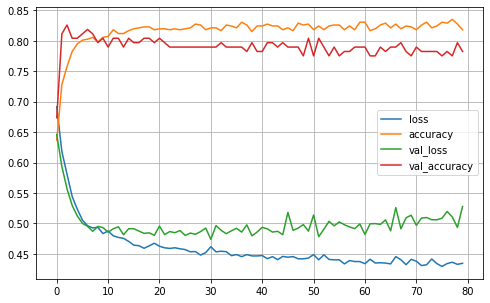

In [346]:
regularizerDense =partial(keras.layers.Dense, kernel_regularizer=keras.regularizers.l2(0.002))

modelANN = keras.models.Sequential([
    regularizerDense(270, activation ="relu"),keras.layers.Dropout(rate=0.2),
    regularizerDense(1, activation ="sigmoid")
    ])


modelANN.compile(loss="binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=0.001,decay=0.000001, 
                                                                               beta_1=0.9, beta_2=0.999), 
                 metrics=["accuracy"])


history = modelANN.fit(df_train_scaled, y_train, epochs=80, validation_data=(df_val_scaled, y_val))
modelANN.evaluate(df_test_scaled,y_test)
pandas.DataFrame(history.history).plot(figsize=(8,5))
plot.grid(True)
plot.show()





In [369]:
result = pandas.DataFrame(data = [(0.433,0.814,0.446,0.809),(0.528,0.783, 0.447, 0.833), (0.471,0.841,0.421,0.862)],
                          index= ['Training', 'Validation', 'Testing'],columns= ['Tensorflow Loss', 'Tensorflow Accuracy', 
                                                                                 'Scratch Loss', 'Scratch Accuracy'])

In [370]:
result

,Tensorflow Loss,Tensorflow Accuracy,Scratch Loss,Scratch Accuracy
Training,0.433,0.814,0.446,0.809
Validation,0.528,0.783,0.447,0.833
Testing,0.471,0.841,0.421,0.862
